In [66]:
!pip install nltk
!pip install textblob
import nltk
import re
import csv
import pandas
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neighbors
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to C:\Users\pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pablo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Apartado 2. Limpieza de texto

In [67]:
#Función para obtener un texto limpio a patir de un texto normal
def limpiar_texto(texto):
    # Eliminar menciones, hashtags, URLs y otros símbolos extraños
    texto = re.sub(r'http\S+', '', texto)  # eliminar URLs
    texto = re.sub(r'#\w+', '', texto)  # eliminar hashtags
    texto = re.sub(r'@\w+', '', texto)  # eliminar menciones
    texto = re.sub(r'[^\w\s]', '', texto)  # eliminar otros símbolos extraños
    
    # Convertir el texto a minúsculas
    texto = texto.lower()
    
    # Tokenización
    tokens = word_tokenize(texto)
    
    # Eliminación de stop words y lematización
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    palabras_limpias = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Unir las palabras limpias en una sola cadena de texto
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio


### Apartado 3. Etiquetado de texto

In [68]:
# Función para etiquetar un texto ya limpio
def etiquetar(texto):
    # Crear un objeto TextBlob con el texto a analizar
    blob = TextBlob(texto)
    # Obtener el valor del análisis de sentimiento
    sentimiento = blob.sentiment.polarity
    # Asignar una etiqueta en función del valor del sentimiento
    if sentimiento >= 0.7:
        etiqueta = "Muy feliz"
    elif sentimiento >= 0.3:
        etiqueta = "Contento"
    elif sentimiento >= -0.3:
        etiqueta = "Neutro"
    elif sentimiento >= -0.7:
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta

In [69]:
# Función para calcular el etiquetado según el número
def calculo_etiqueta_valor(numero):
    if numero == '4':
        etiqueta = "Muy feliz"
    elif numero == '3':
        etiqueta = "Contento"
    elif numero == '2':
        etiqueta = "Neutro"
    elif numero == '1':
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta
    

### Añadir datos al csv

In [70]:
def agregar_columna(input_file):
    with open(input_file, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        rows = list(reader)
        header = rows[0]
        # Añadimos las 3 nuevas columnas
        header.append('Texto limpio')
        header.append('Valor propuesto')
        header.append('Valor calculado')
        for i in range(1, len(rows)):
            # Usamos la columna en la cuál está el texto en bruto
            valor_columna = rows[i][2]  
            # Limpiamos el texto para que pueda ser analizado
            texto_limpio = limpiar_texto(valor_columna)
            # Lo etiquetamos
            texto_etiquetado = etiquetar(texto_limpio)
            # Calculamos el etiquetado que nos propuso el csv
            valor_propuesto = calculo_etiqueta_valor(rows[i][1])
            # Añadimos los nuevos valores
            rows[i].append(texto_limpio) 
            rows[i].append(valor_propuesto)
            rows[i].append(texto_etiquetado)  

    # Guardar los cambios en un nuevo archivo CSV
    output_file = 'DatosFinales.csv'
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerows(rows)

In [71]:
agregar_columna('DatosNuevos.csv')

In [72]:
csvDatos = pandas.read_csv('DatosFinales.csv', delimiter=';',encoding = 'latin-1', header=0,
                       names=['id', 'valoración', 'mensaje', 'texto_limpio',
                              'valor_propuesto', 'valor_calculado'])

### Selección de atributos y objetivos

In [73]:
atributo = csvDatos['texto_limpio'].values.astype('U')  # selección de las columnas de atributos
objetivo = csvDatos['valor_propuesto']  # selección de la columna objetivo

In [74]:
# El codificador adecuado para tanto el atributo como el objetivo
# es OrdinalEncoder, ya que trabaja con una lista o array
# unidimensional de sus valores
codificador_atributo = CountVectorizer()
codificador_objetivo = preprocessing.LabelEncoder()
atributo_codificado = codificador_atributo.fit_transform(atributo)
objetivo_codificado = codificador_objetivo.fit_transform(objetivo)

print(codificador_atributo.vocabulary_)
print(codificador_objetivo.classes_)

{'awww': 845, 'thats': 8398, 'bummer': 1402, 'shoulda': 7535, 'got': 3641, 'david': 2251, 'carr': 1543, 'third': 8431, 'day': 2256, 'upset': 8957, 'cant': 1514, 'update': 8938, 'facebook': 3018, 'texting': 8376, 'might': 5397, 'cry': 2141, 'result': 7070, 'school': 7330, 'today': 8520, 'also': 526, 'blah': 1120, 'dived': 2497, 'many': 5200, 'time': 8484, 'ball': 902, 'managed': 5180, 'save': 7301, '50': 199, 'rest': 7063, 'go': 3574, 'bound': 1249, 'whole': 9296, 'body': 1188, 'feel': 3112, 'itchy': 4463, 'like': 4928, 'fire': 3177, 'behaving': 1015, 'im': 4280, 'mad': 5131, 'see': 7388, 'crew': 2111, 'need': 5702, 'hug': 4181, 'hey': 3997, 'long': 5010, 'yes': 9560, 'rain': 6846, 'bit': 1101, 'lol': 4997, 'fine': 3165, 'thanks': 8388, 'hows': 4163, 'nope': 5833, 'didnt': 2412, 'que': 6661, 'muera': 5592, 'spring': 7910, 'break': 1290, 'plain': 6350, 'city': 1755, 'snowing': 7731, 'repierced': 7022, 'ear': 2697, 'couldnt': 2048, 'bear': 968, 'watch': 9180, 'thought': 8442, 'ua': 8829, 

In [75]:
print(pandas.Series(objetivo).value_counts(normalize=True))

Neutro       0.654609
Contento     0.180530
Molesto      0.079013
Muy feliz    0.068178
Hater        0.017670
Name: valor_propuesto, dtype: float64


### Apartado 5. Entrenamiento del modelo

In [76]:
(atributo_entrenamiento, atributo_prueba,
 objetivo_entrenamiento, objetivo_prueba) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributo_codificado, objetivo_codificado,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del conjunto de prueba
        test_size=.33,
        # Estratificamos respecto a la distribución de valores en la variable objetivo
        stratify=objetivo_codificado)

In [77]:
# Comprobamos que el conjunto de prueba contiene el 33 % de los datos, en la misma proporción
# con respecto a la variable objetivo
print('Cantidad de ejemplos de pruebas requeridos:', 5999 * .33)
print('Filas del array de atributos de prueba:', atributo_prueba.shape[0])
print('Longitud del vector de objetivos de prueba:', len(objetivo_prueba))
print('Proporción de clases en el vector de objetivos de prueba:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_prueba)
      ).value_counts(normalize=True))

Cantidad de ejemplos de pruebas requeridos: 1979.67
Filas del array de atributos de prueba: 1980
Longitud del vector de objetivos de prueba: 1980
Proporción de clases en el vector de objetivos de prueba:
Neutro       0.654545
Contento     0.180808
Molesto      0.078788
Muy feliz    0.068182
Hater        0.017677
dtype: float64


In [78]:
# Comprobamos que el conjunto de entrenamiento contiene el resto de los datos, en la misma
# proporción con respecto a la variable objetivo
print('Cantidad de ejemplos de entrenamiento requeridos:', 5999 * .67)
print('Filas del array de atributos de entrenamiento:', atributo_entrenamiento.shape[0])
print('Longitud del vector de objetivos de entrenamiento:', len(objetivo_entrenamiento))
print('Proporción de clases en el vector de objetivos de entrenamiento:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True))

Cantidad de ejemplos de entrenamiento requeridos: 4019.3300000000004
Filas del array de atributos de entrenamiento: 4019
Longitud del vector de objetivos de entrenamiento: 4019
Proporción de clases en el vector de objetivos de entrenamiento:
Neutro       0.654640
Contento     0.180393
Molesto      0.079124
Muy feliz    0.068176
Hater        0.017666
dtype: float64


### Prueba Naive Bayes

In [79]:
clasif_NB = naive_bayes.MultinomialNB(alpha=0.5)
clasif_NB.fit(atributo_entrenamiento, objetivo_entrenamiento)

MultinomialNB(alpha=0.5)

In [80]:
for clase, cantidad_ejemplos_clase, log_probabilidad_clase in zip(
    codificador_objetivo.classes_, clasif_NB.class_count_, clasif_NB.class_log_prior_):
        print(f'Cantidad de ejemplos para la clase {clase}: {cantidad_ejemplos_clase}')
        print(f'Logaritmo de la probabilidad aprendida para la clase {clase}: {log_probabilidad_clase}')

Cantidad de ejemplos para la clase Contento: 725.0
Logaritmo de la probabilidad aprendida para la clase Contento: -1.7126167395945258
Cantidad de ejemplos para la clase Hater: 71.0
Logaritmo de la probabilidad aprendida para la clase Hater: -4.036108517407885
Cantidad de ejemplos para la clase Molesto: 318.0
Logaritmo de la probabilidad aprendida para la clase Molesto: -2.5367370116690235
Cantidad de ejemplos para la clase Muy feliz: 274.0
Logaritmo de la probabilidad aprendida para la clase Muy feliz: -2.68566028806113
Cantidad de ejemplos para la clase Neutro: 2631.0
Logaritmo de la probabilidad aprendida para la clase Neutro: -0.42366911340890745


In [81]:
nuevos_ejemplos = pandas.DataFrame([['im really sick fever'],
                                    ['im happy family friends']], columns=['texto_limpio'])
nuevos_ejemplos

,texto_limpio
0,im really sick fever
1,im happy family friends


In [82]:
predicciones = clasif_NB.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Neutro', 'Neutro'], dtype=object)

In [83]:
clasif_NB.score(atributo_prueba, objetivo_prueba)

0.647979797979798

### Prueba Árboles de Decisión

In [84]:
from sklearn import tree

In [85]:
clasif_CART = tree.DecisionTreeClassifier(
    max_depth=10,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)
clasif_CART.fit(atributo_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=10, random_state=54321)

In [86]:
from matplotlib import pyplot

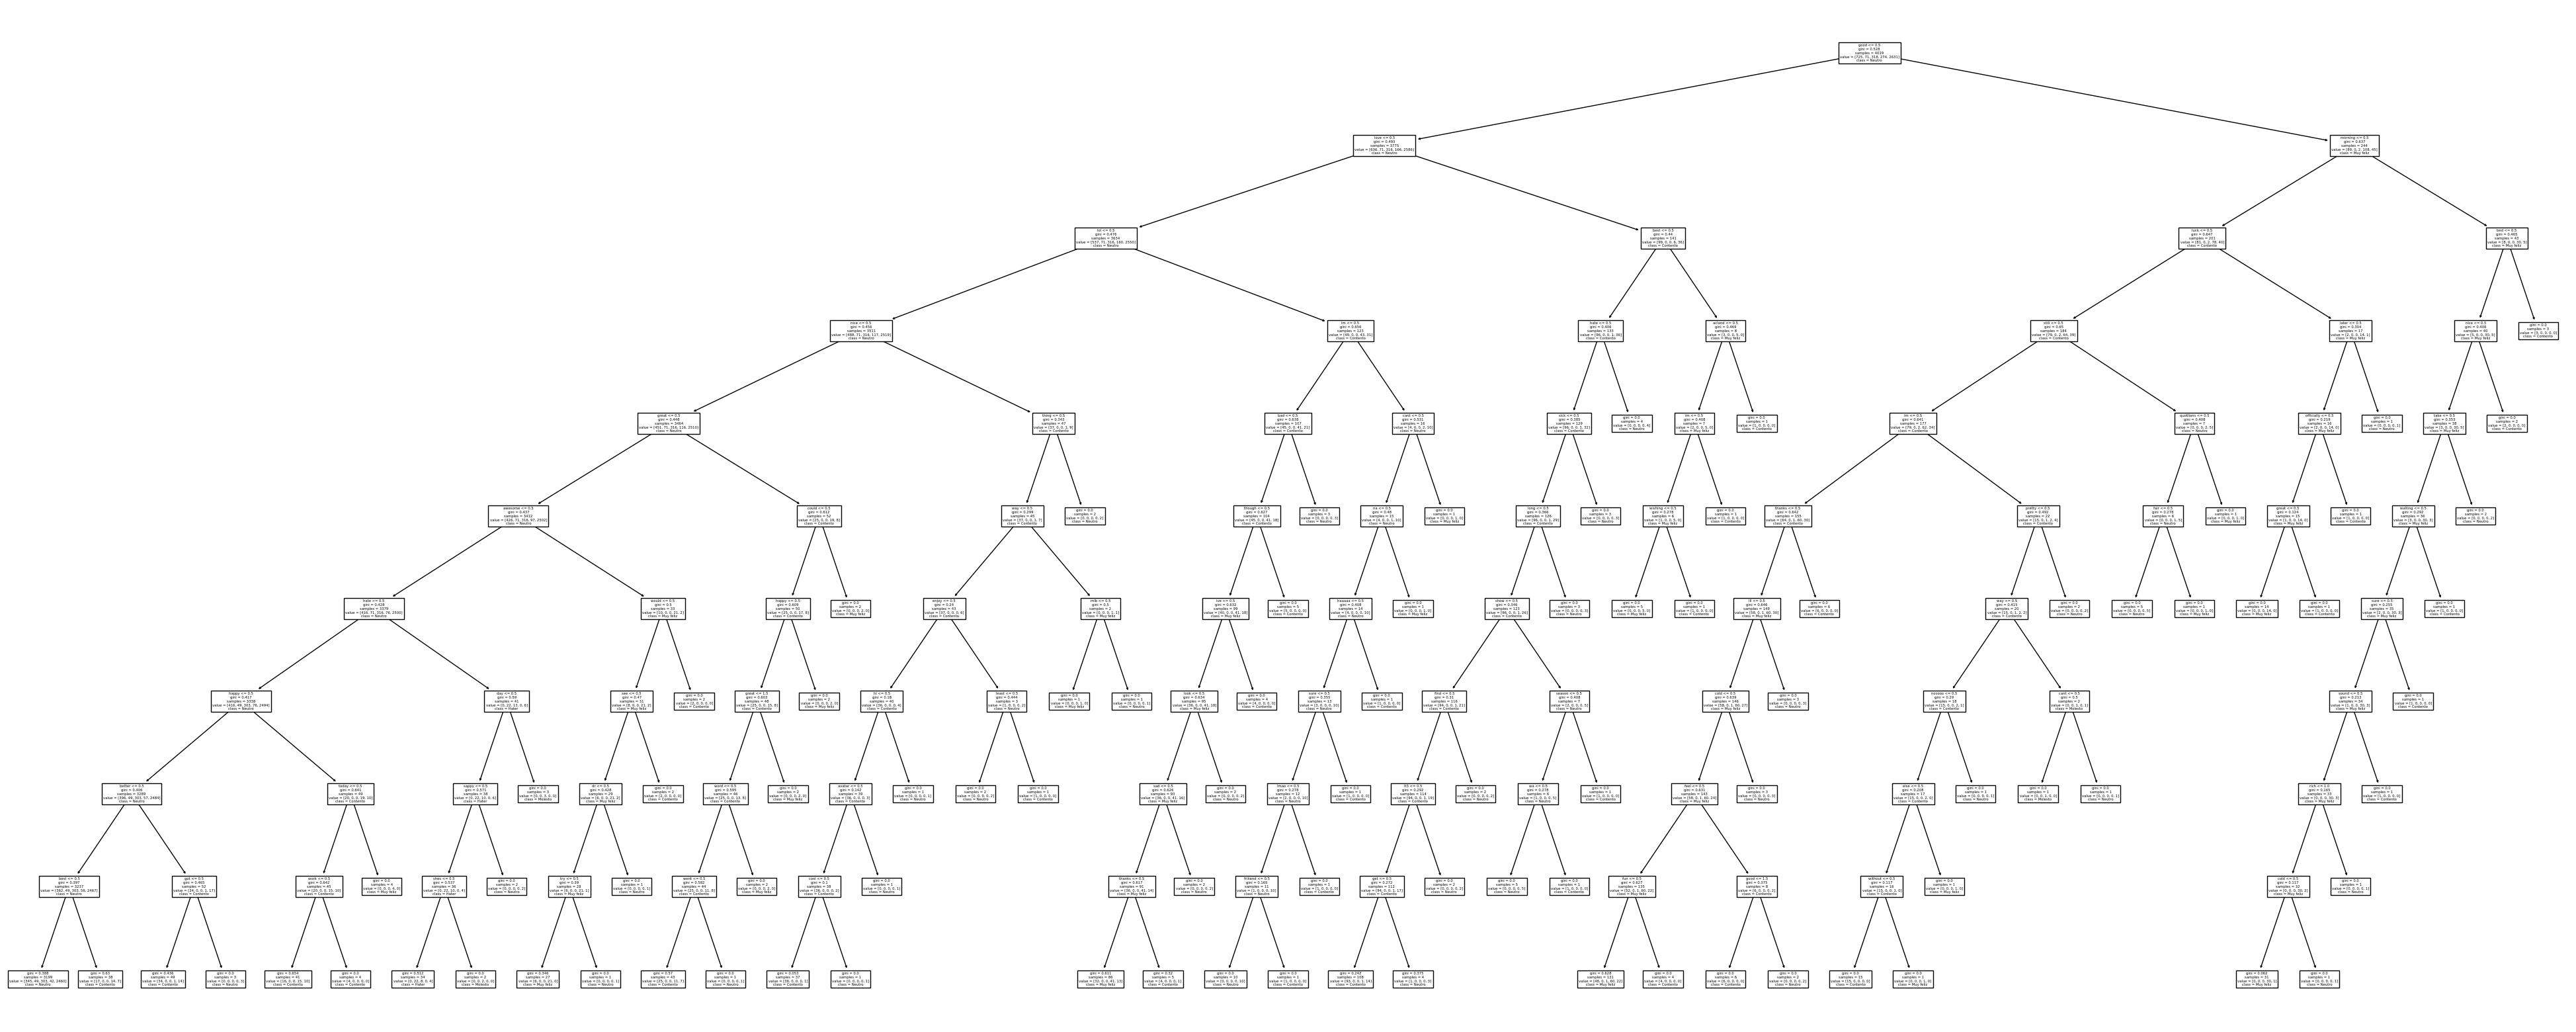

In [87]:
pyplot.figure(figsize=(50, 20))  # Anchura y altura del gráfico
árbol = tree.plot_tree(clasif_CART,
                       feature_names=codificador_atributo.get_feature_names_out(),
                       class_names=codificador_objetivo.classes_)

In [88]:
predicciones = clasif_CART.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Neutro', 'Contento'], dtype=object)

In [89]:
clasif_CART.score(atributo_prueba, objetivo_prueba)

0.7116161616161616

### Prueba KNN

In [90]:
from sklearn import neighbors

In [91]:
clasif_kNN = neighbors.KNeighborsClassifier(
    n_neighbors=5,  # Número de vecinos a considerar
    metric='euclidean'  # Distancia de Hamming como métrica de cercanía:
                      # fracción de atributos con valores distintos
)
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)

KNeighborsClassifier(metric='euclidean')

In [92]:
distancias, vecinos = clasif_kNN.kneighbors(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))

In [93]:
# Vecinos más cercanos y distancia a ellos del primer ejemplo nuevo
print("Primer ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[0]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[0]]),
                       #columns=codificador_atributo.get_feature_names_out(),
                       index=vecinos[0]).assign(
    distancia=distancias[0],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[0]])
))

Primer ejemplo nuevo:
           texto_limpio
0  im really sick fever

5 vecinos más cercanos:
          0      1  distancia      clase
2539     im   None   1.732051     Neutro
3801     im   None   1.732051     Neutro
3964  fever   None   1.732051     Neutro
3382     im  happy   2.000000  Muy feliz
1104     im   boat   2.000000     Neutro


In [94]:
# Vecinos más cercanos y distancia a ellos del segundo ejemplo nuevo
print("Segundo ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[1]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[1]]),
                       #columns=codificador_atributo.get_feature_names_out(),
                       index=vecinos[1]).assign(
    distancia=distancias[1],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[1]])
))

Segundo ejemplo nuevo:
              texto_limpio
1  im happy family friends

5 vecinos más cercanos:
         0       1      2      3  distancia      clase
3382    im   happy   None   None   1.000000  Muy feliz
3801    im    None   None   None   1.414214     Neutro
2539    im    None   None   None   1.414214     Neutro
2359    im    cold   None   None   1.732051    Molesto
43    time  family  happy  spend   1.732051  Muy feliz


In [95]:
predicciones = clasif_kNN.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array(['Neutro', 'Muy feliz'], dtype=object)

In [96]:
clasif_kNN.score(atributo_prueba, objetivo_prueba)

0.6934343434343434

### Validación cruzada de los métodos

In [97]:
#Para Naives Bayes
#creo un diccionario vacio
cv_scores_NB = {}
for k in range(1,11):
    #creo una instancia de modelo Naives Bayes para cada valor de suavizado (del 1 al 10, 11 porque python no coge el último)
    clasif_NB = naive_bayes.MultinomialNB(alpha=k)
    #guardo en cv_scores el resultado de cross_val_score que va hacer una validacion cruzada para cada suavizado
    cv_scores = model_selection.cross_val_score(clasif_NB,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    #lo guardo en el diccionario clave=suavizado, valor=media del resultado de la validacion cruzada para ese suavizado.
    cv_scores_NB[k] = cv_scores.mean()
    
print(cv_scores_NB)
mejor_k_NB = max(cv_scores_NB, key=cv_scores_NB.get)
print(f'Mejor suavizado: {mejor_k_NB}')

{1: 0.6810126425230456, 2: 0.6767856478207467, 3: 0.6705630203099217, 4: 0.6673298098038485, 5: 0.6640953586183794, 6: 0.6621046885274376, 7: 0.6611096636518157, 8: 0.6588702373419684, 9: 0.6593677497797794, 10: 0.6591189935608739}
Mejor suavizado: 1


In [98]:
#Para arboles de decisión con CART
cv_scores_CART = {}
for p in range(5,16):
    clasif_CART = tree.DecisionTreeClassifier(max_depth=p)
    cv_scores = model_selection.cross_val_score(clasif_CART,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    cv_scores_CART[p] = cv_scores.mean()
print(cv_scores_CART)
mejor_p_CART = max(cv_scores_CART, key=cv_scores_CART.get)
print(f'Mejor profundidad: {mejor_p_CART}')

{5: 0.6947029193186188, 6: 0.7024174638031786, 7: 0.7096320144911353, 8: 0.7113726876837756, 9: 0.7138590091934344, 10: 0.7151052716467537, 11: 0.7200797756851652, 12: 0.7210754209004853, 13: 0.7245573876254637, 14: 0.7285374871279513, 15: 0.7290362402451583}
Mejor profundidad: 15


In [99]:
#Para modelo kNN
cv_scores_kNN = {}
for k in range(1,11):
    clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean') 
    cv_scores = model_selection.cross_val_score(clasif_kNN,
                                                atributo_entrenamiento,
                                                objetivo_entrenamiento,
                                                cv=10)
    print(k) #va lento, si imprimes k podrás ver el progreso
    cv_scores_kNN[k] = cv_scores.mean()
print(cv_scores_kNN)
mejor_k_kNN = max(cv_scores_kNN, key=cv_scores_kNN.get)
print(f'Mejor número de vecinos: {mejor_k_kNN}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

10
{1: 0.6907097926824729, 2: 0.6765244848078809, 3: 0.6909597895807743, 4: 0.6996681182615601, 5: 0.6974280716120147, 6: 0.6994224637411447, 7: 0.6966867656728825, 8: 0.6954429845783551, 9: 0.6912128881775661, 10: 0.6937004503666208}
Mejor número de vecinos: 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

### Apartado 6. Predicción de tweets

In [100]:
clasif_CART = tree.DecisionTreeClassifier(max_depth=mejor_p_CART)
clasif_CART.fit(atributo_entrenamiento, objetivo_entrenamiento)
clasif_CART.score(atributo_prueba, objetivo_prueba)

0.7338383838383838

El acierto es del 73%, que es algo que creemos inferior a lo que buscábamos al inicio. Esto se debe a que con 6000 ejemplos pensábamos que el acierto sería mucho mayor, sin embargo, creemos que la principal causa es la diferencia entre todos los tweets, ya que es un mundo sin etiquetas, cada texto es distinto y nadie escribe el mismo tweet 2 veces, por lo tanto, es más complicado entrenar el modelo.

### Apartado 7. Análisis de tweets de personajes públicos